In [65]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
import matplotlib.pyplot as plt
# from sklearn_evaluation import plot

print("Imports complete")

Imports complete


In [ ]:
# Load the data from the text file, ignoring the first line

filename="./data/MiniBooNE_PID.txt"
data=pd.read_csv(filename,delim_whitespace=True,skiprows=1,header=None)
print(data.head(1))
X=data

In [ ]:
""" Create target vector for each row of the dataset. 
The first value in the first row contains the number of signal events, the second the number of background events. 
The target vector should contain 1 for signal events and 0 for background events."""

# Get number of signal and background events
signal, background = open(filename).readline().split()

y = np.concatenate((np.ones(int(signal)), np.zeros(int(background))))
print(y.shape)

In [ ]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
""" save the scaled matrix and the target vector as npy files """
np.save('X.npy', X_scaled)
np.save('y.npy', y)

In [2]:
X=np.load('X.npy') # load the scaled matrix
y=np.load('y.npy')

In [3]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a vanilla neural network classifier and train it on the training data
nn_clf = MLPClassifier(random_state=42)

# Define the hyperparameter space to search over for the vanilla neural network classifier
nn_param_grid = {
    'hidden_layer_sizes': [(40,40)],
    'activation': ["logistic", "tanh", "identity"],
    # 'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500],
    'random_state': [42]
}

# Set up the grid search using 5-fold cross-validation
nn_grid_search = GridSearchCV(nn_clf, nn_param_grid, cv=5, scoring='accuracy',verbose=10)
# nn_grid_search = RandomizedSearchCV(nn_clf, nn_param_grid, cv=5, scoring='accuracy', n_iter=2)

# Perform the grid search on the training set
nn_start_time = time.time()
nn_grid_search.fit(X_train, y_train)
nn_end_time = time.time()
print('Time required to grid search Vanilla Neural Network classifier:', nn_end_time - nn_start_time)

print('Vanilla Neural Network best hyperparameters:', nn_grid_search.best_params_)
print('Vanilla Neural Network best cross-validation accuracy:', nn_grid_search.best_score_)

In [5]:
# Re-train the classifier using the best hyperparameters on the full training set
# nn_clf = nn_grid_search.best_estimator_
nn_clf = MLPClassifier(hidden_layer_sizes=(30,30), activation='relu', max_iter=500, random_state=42)
nn_start_time = time.time()
nn_clf.fit(X_train, y_train)
nn_end_time = time.time()

# Evaluate the classifier on the test set
nn_test_accuracy = nn_clf.score(X_test, y_test)
print('Time required to train Vanilla Neural Network classifier:', nn_end_time - nn_start_time)
print('Vanilla Neural Network test accuracy:', nn_test_accuracy)

Time required to train Vanilla Neural Network classifier: 101.86333680152893
Vanilla Neural Network test accuracy: 0.9393764656133472


In [ ]:
pd.DataFrame(nn_grid_search.cv_results_)

In [ ]:
# Get the results of the grid search
nn_results = nn_grid_search.cv_results_

nn_mean_scores = nn_results['mean_test_score']
nn_mean_times = nn_results['mean_fit_time']
nn_params = nn_results['param_activation']

# Loop through each combination of hyperparameters
for mean_score, mean_time, param in zip(nn_mean_scores, nn_mean_times, nn_params):
    print("HiddenLayerSize: %r | %.2fs | test-score: %f" % (param, mean_time, mean_score))

In [ ]:
""" plot the results of the grid search against the hyperparameter values """
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(nn_params, nn_mean_scores, 'o:', label="Mean Score", linestyle=':')
ax2.plot(nn_params, nn_mean_times, 'o:', color='orange', label="Mean Fit Time")
ax1.set_xlabel('Activation function')
ax1.set_ylabel('Score', color='blue')
ax2.set_ylabel('Fit time [s]', color='orange')

plt.show()

In [4]:
# Create a SVM classifier and train it on the training data
svm_clf = SVC(kernel="rbf",random_state=42)

svm_param_grid = {
    'kernel': ['linear','poly', 'sigmoid'],
    'C': [10],
    'random_state': [42],
}

svm_grid_search = RandomizedSearchCV(svm_clf, svm_param_grid, cv=5, scoring='accuracy', verbose=10, n_iter=10)

svm_start_time = time.time()
svm_grid_search.fit(X_train, y_train)
svm_end_time = time.time()

print('SVM best hyperparameters:', svm_grid_search.best_params_)
print('SVM best cross-validation accuracy:', svm_grid_search.best_score_)
print('Time required to perform GridSearch on SVM classifier:', svm_end_time - svm_start_time, 'seconds')

/home/wi/sdaya001/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START C=10, gamma=auto, kernel=linear, random_state=42............


In [ ]:
svm_clf = svm_grid_search.best_estimator_

svm_start_time = time.time()
svm_clf.fit(X_train, y_train)
svm_end_time = time.time()

svm_test_accuracy = svm_grid_search.score(X_test, y_test)
print('Time required to train SVM classifier:', svm_end_time - svm_start_time)
print('SVM test accuracy:', svm_test_accuracy)

In [ ]:
# Get the results of the grid search
svm_results = svm_grid_search.cv_results_

svm_mean_scores = svm_results['mean_test_score']
svm_mean_score_times = svm_results['mean_score_time']
svm_mean_fit_times = svm_results['mean_fit_time']
svm_param_C = svm_results['param_C']

for mean_score, mean_score_time, mean_fit_time, param in zip(svm_mean_scores, svm_mean_score_times, svm_mean_fit_times, svm_param_C):
    print("C: %r | %.2fs | test-score: %f" % (param, mean_fit_time, mean_score))

In [ ]:
""" plot the results of the grid search against the hyperparameter values """
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(svm_param_C, svm_mean_scores,'o:', color='blue', label="Mean Score")
ax2.plot(svm_param_C, svm_mean_fit_times,'o:', color='orange', label="Mean Fit Time")
ax1.set_xlabel('Regularization parameter')
ax1.set_ylabel('Score', color='blue')
ax2.set_ylabel('Fit time', color='orange')

plt.show()

In [8]:
# Create a random forest classifier and train it on the training data
rf_clf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10,15,20],
    "min_samples_split": [2, 5, 10],
}

rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5, scoring='accuracy', verbose=10)

rf_start_time = time.time()
rf_grid_search.fit(X_train, y_train)
rf_end_time = time.time()

print('RF best hyperparameters:', rf_grid_search.best_params_)
print('RF best cross-validation accuracy:', rf_grid_search.best_score_)
print('Time required to grid search for RF classifier:', rf_end_time - rf_start_time)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START max_depth=10, min_samples_split=2, n_estimators=50.........
[CV 1/5; 1/18] END max_depth=10, min_samples_split=2, n_estimators=50;, score=0.924 total time=  22.6s
[CV 2/5; 1/18] START max_depth=10, min_samples_split=2, n_estimators=50.........
[CV 2/5; 1/18] END max_depth=10, min_samples_split=2, n_estimators=50;, score=0.924 total time=  22.5s
[CV 3/5; 1/18] START max_depth=10, min_samples_split=2, n_estimators=50.........
[CV 3/5; 1/18] END max_depth=10, min_samples_split=2, n_estimators=50;, score=0.924 total time=  22.4s
[CV 4/5; 1/18] START max_depth=10, min_samples_split=2, n_estimators=50.........
[CV 4/5; 1/18] END max_depth=10, min_samples_split=2, n_estimators=50;, score=0.924 total time=  22.3s
[CV 5/5; 1/18] START max_depth=10, min_samples_split=2, n_estimators=50.........
[CV 5/5; 1/18] END max_depth=10, min_samples_split=2, n_estimators=50;, score=0.927 total time=  22.4s
[CV 1/5; 2/18] STAR

In [33]:
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=5, random_state=42)

rf_start_time = time.time()
rf_clf.fit(X_train, y_train)
rf_end_time = time.time()

rf_test_accuracy = rf_clf.score(X_test, y_test)
print('Time required to train RF classifier:', rf_end_time - rf_start_time)
print('RF test accuracy:', rf_test_accuracy)

Time required to train RF classifier: 46.42138051986694
RF test accuracy: 0.9351862530273325


In [ ]:
pd.DataFrame(rf_results)

In [12]:
# Get the results of the grid search
rf_results = rf_grid_search.cv_results_

rf_mean_scores = rf_results['mean_test_score']
rf_mean_fit_times = rf_results['mean_fit_time']
rf_param_min_samples_split  = rf_results['param_min_samples_split']
rf_param_max_depth  = rf_results['param_max_depth']
rf_param_n_estimators  = rf_results['param_n_estimators']

for mean_score, mean_fit_time, n_est, min_sample, max_depth in zip(rf_mean_scores, rf_mean_fit_times, rf_param_n_estimators, rf_param_min_samples_split, rf_param_max_depth):
    print("n_estimators: %r | min_samples_split: %r | max_depth: %r | %.2fs | test-score: %f" % (n_est, min_sample, max_depth, mean_fit_time, mean_score))

n_estimators: 50 | min_samples_split: 2 | max_depth: 10 | 22.33s | test-score: 0.924643
n_estimators: 100 | min_samples_split: 2 | max_depth: 10 | 44.06s | test-score: 0.924883
n_estimators: 50 | min_samples_split: 5 | max_depth: 10 | 22.69s | test-score: 0.924575
n_estimators: 100 | min_samples_split: 5 | max_depth: 10 | 46.42s | test-score: 0.925114
n_estimators: 50 | min_samples_split: 10 | max_depth: 10 | 22.65s | test-score: 0.924864
n_estimators: 100 | min_samples_split: 10 | max_depth: 10 | 45.57s | test-score: 0.925162
n_estimators: 50 | min_samples_split: 2 | max_depth: 15 | 30.71s | test-score: 0.932408
n_estimators: 100 | min_samples_split: 2 | max_depth: 15 | 62.45s | test-score: 0.933225
n_estimators: 50 | min_samples_split: 5 | max_depth: 15 | 30.91s | test-score: 0.932860
n_estimators: 100 | min_samples_split: 5 | max_depth: 15 | 62.23s | test-score: 0.933292
n_estimators: 50 | min_samples_split: 10 | max_depth: 15 | 31.00s | test-score: 0.932552
n_estimators: 100 | min_

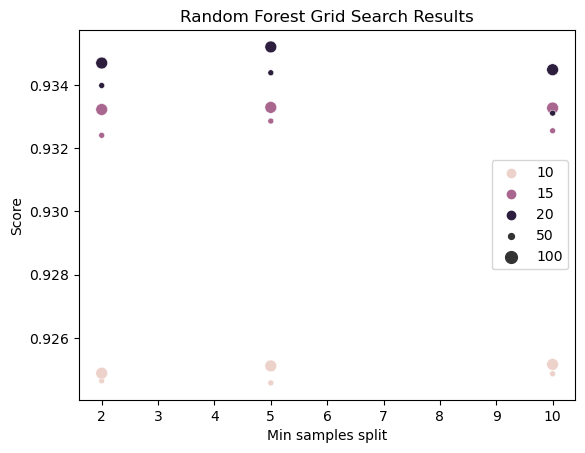

In [29]:
import seaborn as sns
""" plot the results of the grid search against the hyperparameter values """
fig = sns.scatterplot(x=rf_param_min_samples_split, y=rf_mean_scores, hue=rf_param_max_depth, size=rf_param_n_estimators)
fig.set_xlabel('Min samples split')
fig.set_ylabel('Score')
fig.set_title('Random Forest Grid Search Results')
plt.show()

In [37]:
# Generate predictions for the test set
nn_predictions = nn_clf.predict(X_test)
svm_predictions = svm_clf.predict(X_test)
rf_predictions = rf_clf.predict(X_test)

array([0., 1.])

In [51]:
# Define a dictionary that maps model names to their hyperparameters
model_hyperparams = {
    # 'Vanilla Neural Network': nn_grid_search.best_params_,
    # 'SVM': svm_grid_search.best_params_,
    # 'Random Forest': rf_grid_search.best_params_
    'Vanilla Neural Network': {'hidden_layer_sizes': (30, 30), 'activation':'relu', 'max_iter': 500},
    'SVM': {'C': 10},
    'Random Forest': {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
}

# Compute the confusion matrix for each model
nn_confusion_matrix = confusion_matrix(y_test, nn_predictions, labels=nn_clf.classes_)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions, labels=svm_clf.classes_)
rf_confusion_matrix = confusion_matrix(y_test, rf_predictions, labels=rf_clf.classes_)

# Print the confusion matrix and hyperparameters for each model
print('Vanilla Neural Network confusion matrix:')
print(nn_confusion_matrix)
print('Vanilla Neural Network hyperparameters:', model_hyperparams['Vanilla Neural Network'])

print('SVM confusion matrix:')
print(svm_confusion_matrix)
print('SVM hyperparameters:', model_hyperparams['SVM'])

print('Random Forest confusion matrix:')
print(rf_confusion_matrix)
print('Random Forest hyperparameters:', model_hyperparams['Random Forest'])

Vanilla Neural Network confusion matrix:
[[17765   893]
 [  684  6671]]
Vanilla Neural Network hyperparameters: {'hidden_layer_sizes': (30, 30), 'activation': 'relu', 'max_iter': 500}
SVM confusion matrix:
[[17563  1095]
 [ 1286  6069]]
SVM hyperparameters: {'C': 10}
Random Forest confusion matrix:
[[17852   806]
 [  880  6475]]
Random Forest hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}


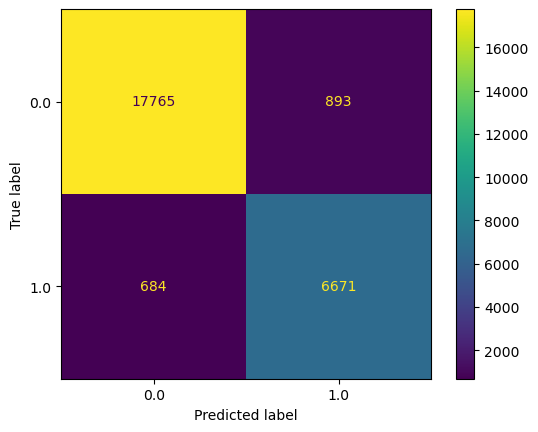

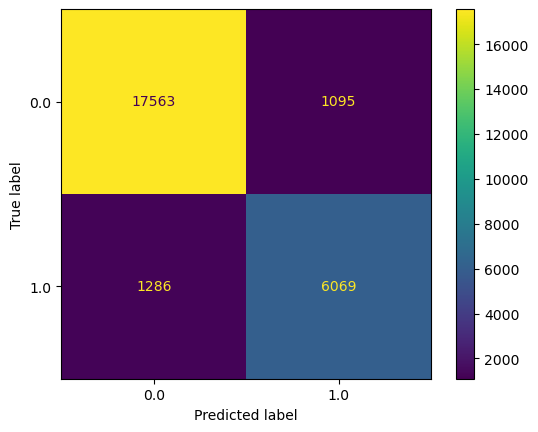

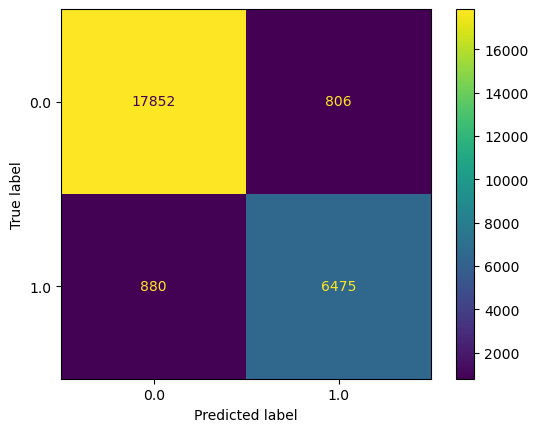

In [63]:
nn_disp_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=nn_confusion_matrix, display_labels=nn_clf.classes_)
svm_disp_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=svm_confusion_matrix, display_labels=svm_clf.classes_)
rf_disp_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=rf_confusion_matrix, display_labels=rf_clf.classes_)

nn_disp_confusion_matrix.plot()
svm_disp_confusion_matrix.plot()
rf_disp_confusion_matrix.plot()

In [66]:
# Evaluate the performance of each classifier
nn_accuracy = accuracy_score(y_test, nn_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Vanilla Neural Network Accuracy:", nn_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

Vanilla Neural Network Accuracy: 0.9393764656133472
SVM Accuracy: 0.908468842501826
Random Forest Accuracy: 0.9351862530273325


In [6]:
from joblib import dump, load

In [7]:
dump(nn_clf, 'nn_clf_2x30_relu.joblib')

['nn_clf_2x30_relu.joblib']

In [ ]:
dump(nn_grid_search, 'nn_grid_search.joblib')

In [ ]:
dump(svm_clf, 'svm_clf.joblib')

In [ ]:
dump(svm_grid_search, 'svm_grid_search.joblib')

In [34]:
dump(rf_clf, 'rf_clf_n50_split5_depth20.joblib')

['rf_clf_n50_split5_depth20.joblib']

In [ ]:
dump(rf_grid_search, 'rf_grid_search.joblib')

In [ ]:
nn_clf = load('nn_clf.joblib')

In [36]:
svm_clf = load('svm_clf_rbf_c10.joblib')

In [ ]:
rf_clf = load('rf_clf.joblib')